In [1]:
# File Directory 
import glob
import os
from os.path import isdir, join
from pathlib import Path

# Math
import numpy as np
from scipy.fftpack import fft
from scipy import signal
import librosa

# Dimension Reduction
from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls

# Data Pre-processing
import pandas as pd
import soundfile
from sklearn.model_selection import KFold

# Deep Learning
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras import Input, layers
from tensorflow.keras import backend as K

# Configuration
py.init_notebook_mode(connected=True)

%matplotlib inline

In [2]:
samples=[]
sample_rates=[]
labels = []
sample_slice_iteration = 0
gunshot_aggregator = {}
glassbreak_aggregator = {}

gunshot_sound_dir = "/home/alexm/Datasets/gunshot_data/gunshot/"

for file in os.listdir(gunshot_sound_dir):
    if file.endswith(".wav"):
        try:
            sample, sample_rate = librosa.load(gunshot_sound_dir + file)
            for i in range(0, sample.size - 44100, 44100):
                sample_slice = sample[i : i + 44100]
                label = 2
                gunshot_aggregator[sample_slice_iteration] = np.max(abs(sample_slice))
                sample_slice_iteration += 1
                if np.max(abs(sample_slice)) < 0.25:
                    label = 0

                samples.append(sample_slice)
                sample_rates.append(sample_rate)
                labels.append(label)
        except:
            sample, sample_rate = soundfile.read(gunshot_sound_dir + file)
            #print("Gunshot sound unrecognized by Librosa:", sample)
            pass
        
glassbreak_sound_dir = "/home/alexm/Datasets/gunshot_data/glassbreak/"

print("...Switching to glassbreak sounds...")

for file in os.listdir(glassbreak_sound_dir):
    if file.endswith(".wav"):
        try:
            sample, sample_rate = librosa.load(glassbreak_sound_dir + file)
            for i in range(0, sample.size - 44100, 44100):
                sample_slice = sample[i : i + 44100]
                label = 1
                glassbreak_aggregator[sample_slice_iteration] = np.max(abs(sample_slice))
                sample_slice_iteration += 1
                if np.max(abs(sample_slice)) < 0.5:
                    label = 0

                samples.append(sample_slice)
                sample_rates.append(sample_rate)
                labels.append(label)
        except:
            sample, sample_rate = soundfile.read(glassbreak_sound_dir + file)
            print("Glassbreak sound unrecognized by Librosa:", sample)
            pass

...Switching to glassbreak sounds...


In [3]:
glassbreak_aggregator_inverted = dict([[v, k] for k, v in glassbreak_aggregator.items()])
for sl in sorted(glassbreak_aggregator.values(), reverse=True):
    print("Max value for slice #" + str(glassbreak_aggregator_inverted[sl]) + " is " + str(sl))

Max value for slice #747 is 1.4094042
Max value for slice #781 is 1.4079254
Max value for slice #673 is 1.3800746
Max value for slice #792 is 1.3733147
Max value for slice #748 is 1.3397317
Max value for slice #791 is 1.3280404
Max value for slice #711 is 1.3101249
Max value for slice #712 is 1.2412102
Max value for slice #815 is 1.2408372
Max value for slice #642 is 1.2344369
Max value for slice #822 is 1.2249558
Max value for slice #859 is 1.2165471
Max value for slice #861 is 1.1716442
Max value for slice #749 is 1.1360332
Max value for slice #802 is 1.1328156
Max value for slice #793 is 1.132382
Max value for slice #865 is 1.1187907
Max value for slice #753 is 1.1181313
Max value for slice #853 is 1.1179487
Max value for slice #575 is 1.0977772
Max value for slice #701 is 1.0860964
Max value for slice #860 is 1.0793438
Max value for slice #536 is 1.0683348
Max value for slice #539 is 1.0660707
Max value for slice #740 is 1.0645065
Max value for slice #667 is 1.0617299
Max value for

In [4]:
print(len(samples))
i=744
samp=samples[i]
sr=sample_rates[i]
print(np.max(abs(samp)))
print(labels[i])
ipd.Audio(samp, rate=sr)

868
0.5526015
1


In [5]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

Text(0.5, 0, 'Seconds')

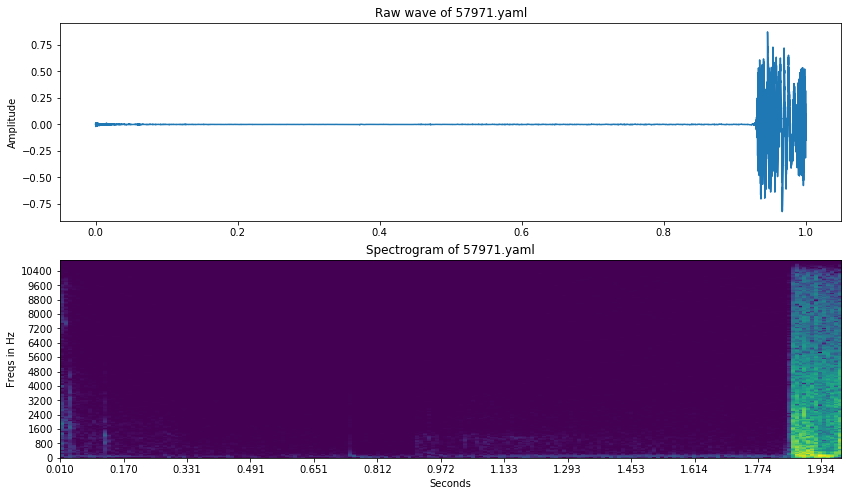

In [6]:
i=15
samp=samples[i]
sr=sample_rates[i]

freqs, times, spectrogram = log_specgram(samp, sr)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + file)
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, 1,samp.size), samp)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + file)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

In [7]:
kf = KFold(n_splits=3, shuffle=True)
samples = np.array(samples)
labels = np.array(labels)
for train_index, test_index in kf.split(samples):
    print("TRAIN:", train_index, "TEST:", test_index)
    train_wav, test_wav = samples[train_index], samples[test_index]
    train_label, test_label = labels[train_index], labels[test_index]

TRAIN: [  0   2   4   5   6   8   9  10  11  12  13  14  18  21  24  26  28  29
  30  31  33  35  36  37  38  39  40  41  42  44  46  47  48  49  51  52
  53  55  56  58  61  62  63  65  67  68  69  72  74  75  76  80  81  82
  84  86  89  90  91  92  93  94  96  97  99 100 101 102 103 105 107 108
 109 113 114 115 116 117 119 120 121 122 123 125 126 127 129 130 131 132
 133 134 136 144 145 147 148 149 151 152 153 154 156 157 158 159 160 161
 163 164 166 167 168 169 170 173 174 175 176 177 181 182 183 187 188 191
 192 193 194 195 196 198 199 202 203 204 206 207 208 209 210 211 212 214
 215 216 217 220 222 223 224 228 230 236 242 243 245 247 248 249 250 251
 253 254 256 258 260 262 263 264 265 267 268 269 271 273 275 277 281 282
 283 285 286 287 289 290 292 293 294 295 296 298 299 300 302 304 309 313
 314 318 319 321 324 325 326 327 328 329 330 331 332 334 335 338 339 340
 341 342 343 344 345 346 347 348 351 352 357 360 363 366 367 369 370 371
 372 373 374 375 378 379 382 383 388 390 392

In [10]:
# Parameters
lr = 0.001
generations = 20000
num_gens_to_wait = 250
batch_size = 256
drop_out_rate = 0.2
input_shape = (44100,1)

In [11]:
#For Conv1D add Channel
train_wav = np.array(train_wav)
test_wav = np.array(test_wav)
train_wav = train_wav.reshape(-1,44100,1)
test_wav = test_wav.reshape(-1,44100,1)
train_label = keras.utils.to_categorical(train_label, 3)
test_label = keras.utils.to_categorical(test_label, 3)

In [13]:
print(train_wav.shape)

(579, 44100, 1)


In [14]:
input_tensor = Input(shape=input_shape)

x = layers.Conv1D(8, 11, padding='valid', activation='relu', strides=1)(input_tensor)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(16, 7, padding='valid', activation='relu', strides=1)(x)
x = layers.MaxPooling1D(4)(x)
x = layers.Conv1D(32, 5, padding='valid', activation='relu', strides=1)(x)
x = layers.MaxPooling1D(4)(x)
x = layers.Conv1D(64, 5, padding='valid', activation='relu', strides=1)(x)
x = layers.MaxPooling1D(6)(x)
x = layers.Conv1D(128, 3, padding='valid', activation='relu', strides=1)(x)
x = layers.MaxPooling1D(6)(x)
x = layers.Conv1D(256, 3, padding='valid', activation='relu', strides=1)(x)
x = layers.MaxPooling1D(6)(x)
x = layers.Flatten()(x)
x = layers.Dense(100, activation='relu')(x)
x = layers.Dropout(drop_out_rate)(x)
x = layers.Dense(50, activation='relu')(x)
x = layers.Dropout(drop_out_rate)(x)
x = layers.Dense(20, activation='relu')(x)
output_tensor = layers.Dense(3, activation='softmax')(x)

model = tf.keras.Model(input_tensor, output_tensor)

model.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.Adam(lr = lr),
             metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 44100, 1)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 44090, 8)          96        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 22045, 8)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 22039, 16)         912       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 5509, 16)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 5505, 32)          2592      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 1376, 32)          0         
__________

In [16]:
model.fit(train_wav, train_label, 
          validation_data=[test_wav, test_label],
          batch_size=batch_size, 
          epochs=50,
          verbose=1)

Train on 579 samples, validate on 289 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
579/579 [==============================] - 4s 7ms/sample - loss: 1.0894 - acc: 0.4957 - val_loss: 1.0343 - val_acc: 0.6747
Epoch 2/50
579/579 [==============================] - 2s 3ms/sample - loss: 1.0312 - acc: 0.6546 - val_loss: 0.9374 - val_acc: 0.6851
Epoch 3/50
579/579 [==============================] - 2s 3ms/sample - loss: 0.9638 - acc: 0.6736 - val_loss: 0.8990 - val_acc: 0.7336
Epoch 4/50
579/579 [==============================] - 2s 3ms/sample - loss: 0.8959 - acc: 0.7772 - val_loss: 0.8288 - val_acc: 0.7647
Epoch 5/50
579/579 [==============================] - 2s 3ms/sample - loss: 0.8225 - acc: 0.7634 - val_loss: 0.7234 - val_acc: 0.7509
Epoch 6/50
579/579 [==============================] - 2s 3ms/sample - loss: 0.7007 - acc: 0.7720 - val_loss: 0.6365 - val_acc: 0.7647
Epoch 7/50
579/579 [==============================] - 2s 3ms/sample - loss: 0.6037 - acc: 0.7824 - val

In [26]:
Y_test_pred = model.predict(test_wav)
y_predicted_classes_test = Y_test_pred.argmax(axis=-1)
y_actual_classes_test= test_label.argmax(axis=-1)
wrong_examples = np.nonzero(y_predicted_classes_test != y_actual_classes_test)

(289,)


In [18]:
print(wrong_examples)

(array([  1,   5,  19,  41,  50,  52,  55,  57,  58,  64,  65,  67,  75,
        81, 112, 115, 116, 120, 121, 135, 138, 158, 193, 209, 224, 225,
       232, 235, 249, 256, 270, 284, 285, 287]),)


In [19]:
i=1
samp=np.reshape(test_wav[i],44100,)
sr=sample_rates[i]
print(y_test[i],Y_test_pred[i])
ipd.Audio(samp, rate=sr)

2 [0.554347   0.3448235  0.10082955]


In [ ]:
i=5
samp=np.reshape(test_wav[i],44100,)
sr=sample_rates[i]
print(y_test[i],Y_test_pred[i])
ipd.Audio(samp, rate=sr)

In [17]:
i=19
samp=np.reshape(test_wav[i],44100,)
sr=sample_rates[i]
print(y_test[i],Y_test_pred[i])
ipd.Audio(samp, rate=sr)

0 [0.9313842  0.06127589 0.00733979]


In [18]:
i=41
samp=np.reshape(test_wav[i],44100,)
sr=sample_rates[i]
print(y_test[i],Y_test_pred[i])
ipd.Audio(samp, rate=sr)

2 [5.9865852e-06 5.2870007e-07 9.9999344e-01]


In [19]:
i=50
samp=np.reshape(test_wav[i],44100,)
sr=sample_rates[i]
print(y_test[i],Y_test_pred[i])
ipd.Audio(samp, rate=sr)

2 [0.7274393  0.1795184  0.09304236]
